In [20]:
# 1. Imports
import numpy as np
import pandas as pd
from pathlib import Path
import sys

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Load from featured engineered dataset
ROOT = Path.cwd().resolve().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

engineered_path = ROOT / "data" / "processed" / "loan_default_engineered.csv"
df = pd.read_csv(engineered_path)

print("Loaded:", engineered_path)
print("Shape:", df.shape)
df.head()

Loaded: C:\Users\sauna\DS Projects\Financial_Analytics_LDP\data\processed\loan_default_engineered.csv
Shape: (10000, 8)


,employed,bank_balance,annual_salary,DEFAULT,log_bank_balance,log_annual_salary,balance_to_salary,employed_x_log_salary
0,1,8754.36,532339.56,0,9.077421,13.185039,0.016445,13.185039
1,0,9806.16,145273.56,0,9.190868,11.886381,0.067501,0.000000
2,1,12882.60,381205.68,0,9.463710,12.851097,0.033794,12.851097
3,1,6351.00,428453.88,0,8.756525,12.967941,0.014823,12.967941
4,1,9427.92,461562.00,0,9.151537,13.042374,0.020426,13.042374


In [15]:
TARGET = "DEFAULT"

# choose engineered features (you can tweak this list)
FEATURES = [
    "employed",
    "log_bank_balance",
    "log_annual_salary",
    "balance_to_salary",
    "employed_x_log_salary",
]

# X, y
X = df[FEATURES].copy()
y = df[TARGET].copy()

# stratified split to keep class ratio similar in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train class ratio:", y_train.mean().round(4))
print("Test class ratio :", y_test.mean().round(4))


Train: (8000, 5) Test: (2000, 5)
Train class ratio: 0.0332
Test class ratio : 0.0335


=== Logistic Regression (class-weighted) ===
              precision    recall  f1-score   support

           0      0.995     0.831     0.906      1933
           1      0.153     0.881     0.260        67

    accuracy                          0.833      2000
   macro avg      0.574     0.856     0.583      2000
weighted avg      0.967     0.833     0.884      2000

ROC-AUC : 0.9485140258356433
PR-AUC  : 0.4602560116957304


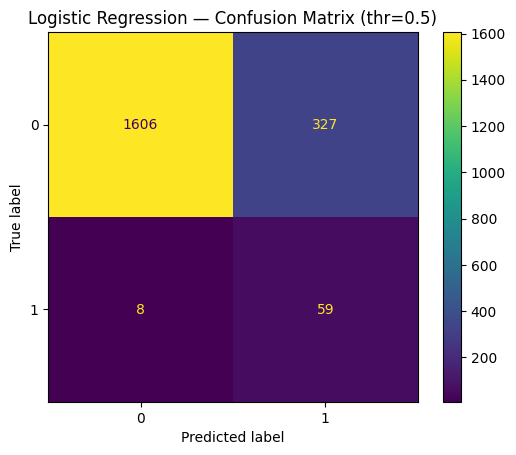

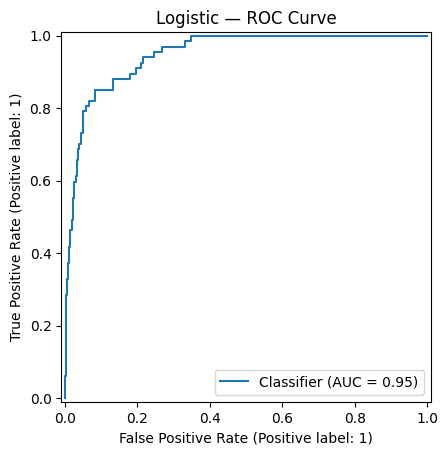

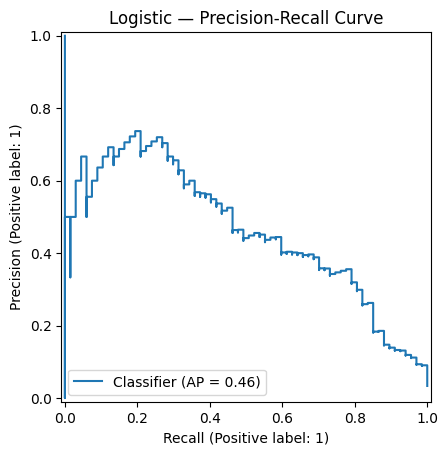

In [16]:
# pipeline: scale -> logistic (class-weighted)
logit = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        solver="liblinear"  # stable for small feature sets
    ))
])

# fit
logit.fit(X_train, y_train)

# predictions
y_pred_lr = logit.predict(X_test)
y_proba_lr = logit.predict_proba(X_test)[:, 1]

# metrics
print("=== Logistic Regression (class-weighted) ===")
print(classification_report(y_test, y_pred_lr, digits=3, zero_division=0))
print("ROC-AUC :", roc_auc_score(y_test, y_proba_lr))
print("PR-AUC  :", average_precision_score(y_test, y_proba_lr))

# confusion matrix at threshold 0.5 (just a sanity view)
cm = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay(cm).plot()
plt.title("Logistic Regression — Confusion Matrix (thr=0.5)")
plt.show()

# ROC & PR curves
RocCurveDisplay.from_predictions(y_test, y_proba_lr)
plt.title("Logistic — ROC Curve")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba_lr)
plt.title("Logistic — Precision-Recall Curve")
plt.show()

=== Random Forest (class-weighted) ===
              precision    recall  f1-score   support

           0      0.977     0.990     0.983      1933
           1      0.512     0.313     0.389        67

    accuracy                          0.967      2000
   macro avg      0.744     0.652     0.686      2000
weighted avg      0.961     0.967     0.963      2000

ROC-AUC : 0.893352688188648
PR-AUC  : 0.39203094807851946


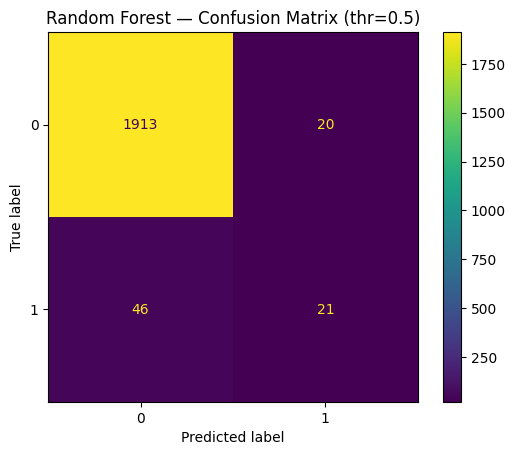

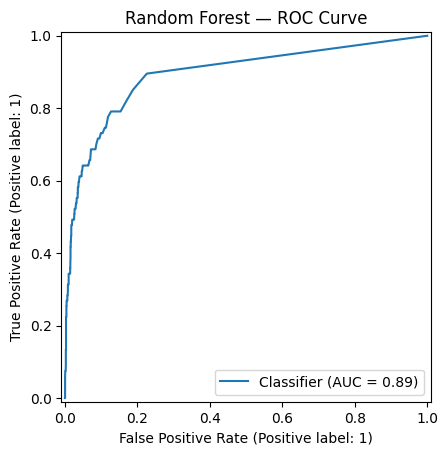

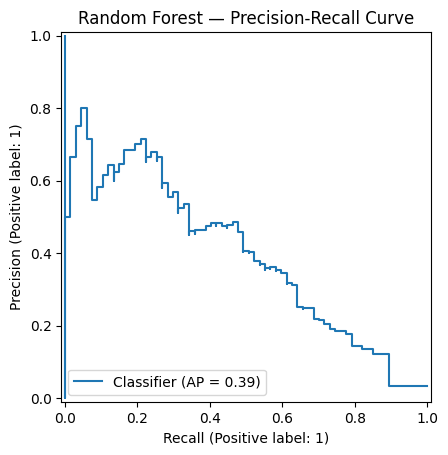

In [17]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"  # handle imbalance
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("=== Random Forest (class-weighted) ===")
print(classification_report(y_test, y_pred_rf, digits=3, zero_division=0))
print("ROC-AUC :", roc_auc_score(y_test, y_proba_rf))
print("PR-AUC  :", average_precision_score(y_test, y_proba_rf))

cm = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm).plot()
plt.title("Random Forest — Confusion Matrix (thr=0.5)")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.title("Random Forest — ROC Curve")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba_rf)
plt.title("Random Forest — Precision-Recall Curve")
plt.show()

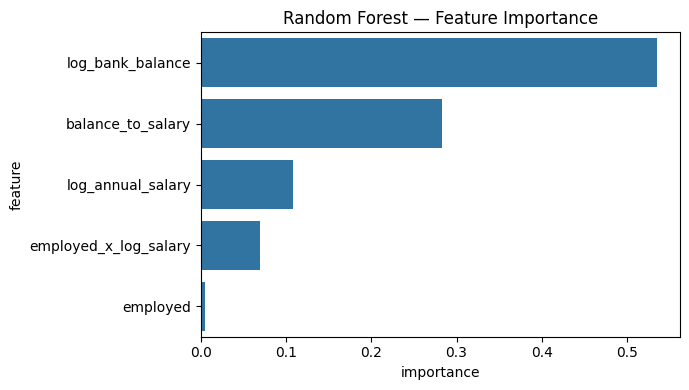

,feature,importance
0,log_bank_balance,0.535485
1,balance_to_salary,0.282876
2,log_annual_salary,0.107507
3,employed_x_log_salary,0.069685
4,employed,0.004446


In [19]:
imp = pd.Series(rf.feature_importances_, index=FEATURES).sort_values(ascending=False)
imp_df = imp.reset_index()
imp_df.columns = ["feature", "importance"]

plt.figure(figsize=(7,4))
sns.barplot(data=imp_df, x="importance", y="feature")
plt.title("Random Forest — Feature Importance")
plt.tight_layout()
plt.show()

imp_df

In [21]:
def topk_capture(y_true, y_scores, k=0.05):
    """
    y_true: 0/1 ground truth
    y_scores: predicted probabilities for class 1
    k: top-k fraction (e.g., 0.05 = top 5%)
    Returns: dict with capture rate and simple table
    """
    n = len(y_true)
    cutoff = int(np.ceil(k * n))
    order = np.argsort(-y_scores)  # descending by score
    top_idx = order[:cutoff]
    captured_defaults = y_true.iloc[top_idx].sum()
    total_defaults = y_true.sum()
    capture_rate = captured_defaults / total_defaults if total_defaults > 0 else np.nan

    table = pd.DataFrame({
        "rank": np.arange(1, cutoff+1),
        "y_true": y_true.iloc[top_idx].values,
        "score": y_scores[top_idx]
    })
    return {
        "k": k,
        "n_in_bucket": cutoff,
        "defaults_in_bucket": int(captured_defaults),
        "total_defaults": int(total_defaults),
        "capture_rate": float(capture_rate),
        "table": table.head(10)  # peek top 10
    }

for name, proba in [("Logistic", y_proba_lr), ("RandomForest", y_proba_rf)]:
    stats_5 = topk_capture(y_test.reset_index(drop=True), proba, k=0.05)
    stats_10 = topk_capture(y_test.reset_index(drop=True), proba, k=0.10)
    print(f"\n=== {name}: Top-5% ===")
    print({k: v for k, v in stats_5.items() if k != "table"})
    display(stats_5["table"])
    print(f"=== {name}: Top-10% ===")
    print({k: v for k, v in stats_10.items() if k != "table"})
    display(stats_10["table"])


=== Logistic: Top-5% ===
{'k': 0.05, 'n_in_bucket': 100, 'defaults_in_bucket': 40, 'total_defaults': 67, 'capture_rate': 0.5970149253731343}


,rank,y_true,score
0,1,0,0.986563
1,2,1,0.982075
2,3,0,0.979407
3,4,1,0.978454
4,5,1,0.977545
5,6,1,0.973830
6,7,0,0.972892
7,8,0,0.971222
8,9,1,0.970230
9,10,1,0.969992


=== Logistic: Top-10% ===
{'k': 0.1, 'n_in_bucket': 200, 'defaults_in_bucket': 55, 'total_defaults': 67, 'capture_rate': 0.8208955223880597}


,rank,y_true,score
0,1,0,0.986563
1,2,1,0.982075
2,3,0,0.979407
3,4,1,0.978454
4,5,1,0.977545
5,6,1,0.973830
6,7,0,0.972892
7,8,0,0.971222
8,9,1,0.970230
9,10,1,0.969992



=== RandomForest: Top-5% ===
{'k': 0.05, 'n_in_bucket': 100, 'defaults_in_bucket': 37, 'total_defaults': 67, 'capture_rate': 0.5522388059701493}


,rank,y_true,score
0,1,0,0.963333
1,2,1,0.936667
2,3,1,0.886667
3,4,1,0.876667
4,5,1,0.873333
5,6,0,0.856667
6,7,1,0.856667
7,8,0,0.840000
8,9,0,0.840000
9,10,0,0.836667


=== RandomForest: Top-10% ===
{'k': 0.1, 'n_in_bucket': 200, 'defaults_in_bucket': 46, 'total_defaults': 67, 'capture_rate': 0.6865671641791045}


,rank,y_true,score
0,1,0,0.963333
1,2,1,0.936667
2,3,1,0.886667
3,4,1,0.876667
4,5,1,0.873333
5,6,0,0.856667
6,7,1,0.856667
7,8,0,0.840000
8,9,0,0.840000
9,10,0,0.836667


In [24]:
reports_dir = ROOT / "reports"
reports_dir.mkdir(parents=True, exist_ok=True)

summary = pd.DataFrame({
    "model": ["Logistic", "RandomForest"],
    "roc_auc": [roc_auc_score(y_test, y_proba_lr), roc_auc_score(y_test, y_proba_rf)],
    "pr_auc":  [average_precision_score(y_test, y_proba_lr), average_precision_score(y_test, y_proba_rf)],
})
summary.to_csv(reports_dir / "baseline_summary.csv", index=False)
summary

,model,roc_auc,pr_auc
0,Logistic,0.948514,0.460256
1,RandomForest,0.893353,0.392031
